# Cosmic shear

This example simulates a galaxy catalogue with shears affected by weak lensing, combining the [galaxies](../1-basic/density.ipynb) and [lensing](../1-basic/lensing.ipynb) examples with models for the intrinsic galaxy ellipticity and the resulting shear.

## Setup

The setup of galaxies and weak lensing fields is the same as in the basic examples.
The setup for angular matter power spectra matches the definition from the [Matter shell definition](../1-basic/shells.ipynb) example.

In [ ]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

# use the CAMB cosmology that generated the matter power spectra
import camb
from cosmology import Cosmology

# almost all GLASS functionality is available from the `glass` namespace
import glass
import glass.ext.camb

# how many arcmin2 over the entire sphere
ARCMIN2_SPHERE = 60**6 // 100 / np.pi

# creating a numpy random number generator for sampling
rng = np.random.default_rng(seed=42)

# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = lmax = 256

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(
    H0=100 * h,
    omch2=Oc * h**2,
    ombh2=Ob * h**2,
    NonLinear=camb.model.NonLinear_both,
)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

# shells of 200 Mpc in comoving distance spacing
zb = glass.distance_grid(cosmo, 0.0, 1.0, dx=200.0)

# linear window function for shells
shells = glass.linear_windows(zb)

# compute the angular matter power spectra of the shells with CAMB
cls = glass.ext.camb.matter_cls(pars, lmax, shells)

## Matter

In [ ]:
# set up lognormal matter fields for simulation
fields = glass.lognormal_fields(shells)

# apply discretisation to the full set of spectra:
# - HEALPix pixel window function (`nside=nside`)
# - maximum angular mode number (`lmax=lmax`)
# - number of correlated shells (`ncorr=3`)
cls = glass.discretized_cls(cls, nside=nside, lmax=lmax, ncorr=3)

# compute Gaussian spectra for lognormal fields from discretised spectra
gls = glass.solve_gaussian_spectra(fields, cls)

# generator for lognormal matter fields
matter = glass.generate(fields, gls, nside, ncorr=3, rng=rng)

## Lensing

In [ ]:
# this will compute the convergence field iteratively
convergence = glass.MultiPlaneConvergence(cosmo)

## Galaxies

In [ ]:
# standard deviation in each component of galaxy ellipticity
# this is very small so that the galaxy density can be small, too
sigma_e = 0.01

# galaxy number density per arcmin2, over all shells
n_arcmin2 = 0.01

# localised redshift distribution with the given density
z = np.arange(0.0, 2.0, 0.01)
dndz = np.exp(-((z - 0.5) ** 2) / (0.1) ** 2)
dndz *= n_arcmin2 / np.trapezoid(dndz, z)

# distribute dN/dz over the radial window functions
ngal = glass.partition(z, dndz, shells)

## Simulation

Simulate the galaxies with shears.
In each iteration, get the shears and map them to a HEALPix map for later analysis.

In addition, generate the galaxy ellipticities, drawn from the intrinsic normal distribution.
The standard deviation is much too small to be realistic, but enables the example to get away with fewer total galaxies.

Finally, apply the reduced shear from the lensing maps to the galaxy ellipticities, producing the galaxy shears.

In [ ]:
# number of HEALPix pixels in the maps
npix = 12 * nside**2

# map for galaxy numbers
num = np.zeros(npix)

# map for sum of shears
she = np.zeros(npix, dtype=complex)

# simulate the matter fields in the main loop
for i, delta_i in enumerate(matter):
    # compute the lensing maps for this shell
    convergence.add_window(delta_i, shells[i])
    kappa_i = convergence.kappa
    gamm1_i, gamm2_i = glass.shear_from_convergence(kappa_i)

    # generate galaxy positions uniformly over the sphere
    for gal_lon, gal_lat, gal_count in glass.uniform_positions(ngal[i], rng=rng):
        # generate galaxy ellipticities from the chosen distribution
        gal_eps = glass.ellipticity_intnorm(gal_count, sigma_e, rng=rng)

        # apply the shear fields to the ellipticities
        gal_she = glass.galaxy_shear(
            gal_lon,
            gal_lat,
            gal_eps,
            kappa_i,
            gamm1_i,
            gamm2_i,
        )

        # map the galaxy shears to a HEALPix map; this is opaque but works
        gal_pix = hp.ang2pix(nside, gal_lon, gal_lat, lonlat=True)
        s = np.argsort(gal_pix)
        pix, start, count = np.unique(gal_pix[s], return_index=True, return_counts=True)
        num[pix] += count
        she[pix] += list(map(np.sum, np.split(gal_she[s], start[1:])))

## Analysis

Compute the angular power spectrum of the observed galaxy shears.
To compare with the expectation, take into account the expected noise level due to shape noise, and the expected mixing matrix for a uniform distribution of points.

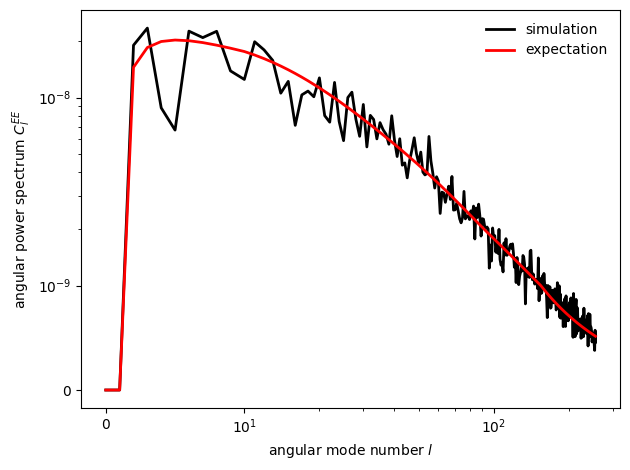

In [ ]:
# compute the expected number of galaxies in each pixel
nbar = ARCMIN2_SPHERE / npix * n_arcmin2

# normalise the maps by the expected number of galaxies in each pixel
she /= nbar
num /= nbar

# get the angular power spectra from the galaxy shears
cls = hp.anafast([num, she.real, she.imag], pol=True, lmax=lmax, use_pixel_weights=True)

# get the theory cls from CAMB
pars.NonLinear = "NonLinear_both"
pars.Want_CMB = False
pars.min_l = 1
pars.set_for_lmax(lmax)
pars.SourceWindows = [
    camb.sources.SplinedSourceWindow(z=z, W=dndz, source_type="lensing"),
]
theory_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)

# factor transforming convergence to shear
ell = np.arange(lmax + 1)
fl = (ell + 2) * (ell + 1) * ell * (ell - 1) / np.clip(ell**2 * (ell + 1) ** 2, 1, None)

# the noise level from discrete observations with shape noise
ntot = nbar * npix
nl = 4 * np.pi / ntot * sigma_e**2 * (ell >= 2)

# mixing matrix for uniform distribution of points
mm = (1 - 1 / ntot) * np.eye(lmax + 1, lmax + 1) + (ell + 1 / 2) / ntot
mm[:2, :] = mm[:, :2] = 0

# the shear pixel window function for HEALPix
_, pw = hp.pixwin(nside, lmax=lmax, pol=True)

# plot the realised and expected cls
plt.plot(ell, cls[1] - nl, "-k", lw=2, label="simulation")
plt.plot(ell, pw**2 * mm @ (fl * theory_cls["W1xW1"]), "-r", lw=2, label="expectation")
plt.xscale("symlog", linthresh=10, linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.yscale("symlog", linthresh=1e-9, linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel("angular mode number $l$")
plt.ylabel("angular power spectrum $C_l^{EE}$")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()